## IN3050/IN4050 Mandatory Assignment 2, 2023: Supervised Learning

### Rules

Before you begin the exercise, review the rules at this website:

- https://www.uio.no/english/studies/examinations/compulsory-activities/mn-ifi-mandatory.html 

in particular the paragraph on cooperation. This is an individual assignment. You are not allowed to deliver together or copy/share source-code/answers with others. Read also the "Routines for handling suspicion of cheating and attempted cheating at the University of Oslo": 
- https://www.uio.no/english/studies/examinations/cheating/index.html 

By submitting this assignment, you confirm that you are familiar with the rules and the consequences of breaking them.

### Delivery

**Deadline**: Friday, March 24, 2023, 23:59

Your submission should be delivered in Devilry. You may redeliver in Devilry before the deadline, but include all files in the last delivery, as only the last delivery will be read. You are recommended to upload preliminary versions hours (or days) before the final deadline.

### What to deliver?

You are recommended to solve the exercise in a Jupyter notebook, but you might solve it in a Python program if you prefer.

#### Alternative 1
If you choose Jupyter, you should deliver the notebook. You should answer all questions and explain what you are doing in Markdown. Still, the code should be properly commented. The notebook should contain results of your runs. In addition, you should make a pdf of your solution which shows the results of the runs. (If you can't export: notebook -> latex -> pdf on your own machine, you may do this on the IFI linux machines.)

#### Alternative 2
If you prefer not to use notebooks, you should deliver the code, your run results, and a pdf-report where you answer all the questions and explain your work.

Here is a list of *absolutely necessary* (but not sufficient) conditions to get the assignment marked as passed:

- You must deliver your code (python file or notebook) you used to solve the assignment.
- The code used for making the output and plots must be included in the assignment. 
- You must include example runs that clearly shows how to run all implemented functions and methods.
- All the code (in notebook cells or python main-blocks) must run. If you have unfinished code that crashes, please comment it out and document what you think causes it to crash. 
- You must also deliver a pdf of the code, outputs, comments and plots as explained above.

Your report/notebook should contain your name and username.

Deliver one single zipped folder (.zip, .tgz or .tar.gz) which contains your complete solution.

Important: if you weren’t able to finish the assignment, use the PDF report/Markdown to elaborate on what you’ve tried and what problems you encountered. Students who have made an effort and attempted all parts of the assignment will get a second chance even if they fail initially. This exercise will be graded PASS/FAIL.

### Goals of the assignment
The goal of this assignment is to get a better understanding of supervised learning with gradient descent. It will, in particular, consider the similarities and differences between linear classifiers and multi-layer feed forward networks (multi-layer perceptron, MLP) and the differences and similarities between binary and multi-class classification. A main part will be dedicated to implementing and understanding the backpropagation algorithm. 

### Tools
The aim of the exercises is to give you a look inside the learning algorithms. You may freely use code from the weekly exercises and the published solutions. You should not use ML libraries like scikit-learn or tensorflow.

You may use tools like NumPy and Pandas, which are not specific ML-tools.

The given precode uses NumPy. You are recommended to use NumPy since it results in more compact code, but feel free to use pure python if you prefer. 

### Beware
There might occur typos or ambiguities. This is a revised assignment compared to earlier years, and there might be new typos. If anything is unclear, do not hesitate to ask. Also, if you think some assumptions are missing, make your own and explain them!

### Initialization

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn #for datasets

## Datasets

We start by making a synthetic dataset of 2000 datapoints and five classes, with 400 individuals in each class. (See https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html regarding how the data are generated.) We choose to use a synthetic dataset---and not a set of natural occuring data---because we are mostly interested in properties of the various learning algorithms, in particular the differences between linear classifiers and multi-layer neural networks together with the difference between binary and multi-class data.

When we are doing experiments in supervised learning, and the data are not already split into training and test sets, we should start by splitting the data. Sometimes there are natural ways to split the data, say training on data from one year and testing on data from a later year, but if that is not the case, we should shuffle the data randomly before splitting. (OK, that is not necessary with this particular synthetic data set, since it is already shuffled by default by scikit, but that will not be the case with real-world data.) We should split the data so that we keep the alignment between X and t, which may be achieved by shuffling the indices. We split into 50% for training, 25% for validation, and 25% for final testing. The set for final testing *must not be used* till the end of the assignment in part 3.

We fix the seed both for data set generation and for shuffling, so that we work on the same datasets when we rerun the experiments. This is done by the `random_state` argument and the `rng = np.random.RandomState(2022)`.

In [4]:
from sklearn.datasets import make_blobs
X, t_multi = make_blobs(n_samples=[400,400,400, 400, 400], 
                        centers=[[0,1],[4,2],[8,1],[2,0],[6,0]], 
                        cluster_std=[1.0, 2.0, 1.0, 0.5, 0.5],
                        n_features=2, random_state=2022)

In [5]:
indices = np.arange(X.shape[0])
rng = np.random.RandomState(2022)
rng.shuffle(indices)
indices[:10]

array([1018, 1295,  643, 1842, 1669,   86,  164, 1653, 1174,  747])

In [6]:
X_train = X[indices[:1000],:]
X_val = X[indices[1000:1500],:]
X_test = X[indices[1500:],:]
t_multi_train = t_multi[indices[:1000]]
t_multi_val = t_multi[indices[1000:1500]]
t_multi_test = t_multi[indices[1500:]]

Next, we will  make a second dataset by merging classes in (X,t) into two classes and call the new set (X, t2). This will be a binary set.
We now have two datasets:

- Binary set: `(X, t2)`
- Multi-class set: `(X, t_multi)`

In [7]:
t2_train = t_multi_train >= 3
t2_train = t2_train.astype('int')
t2_val = (t_multi_val >= 3).astype('int')
t2_test = (t_multi_test >= 3).astype('int')

We can plot the two traning sets.

Text(0.5, 1.0, 'Multi-class set')

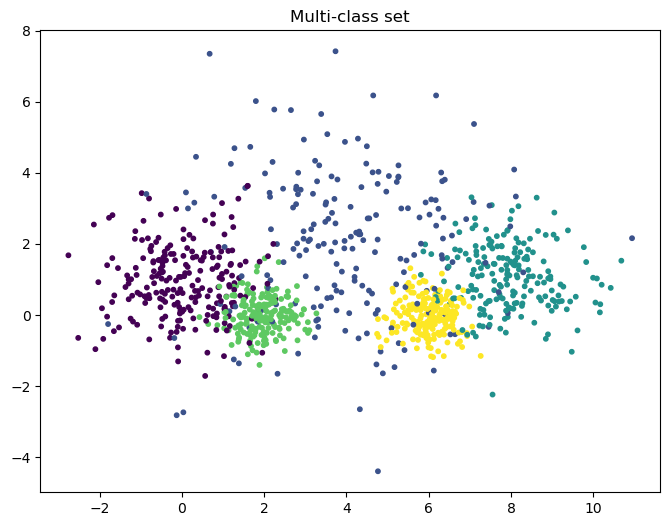

In [8]:
plt.figure(figsize=(8,6)) # You may adjust the size
plt.scatter(X_train[:, 0], X_train[:, 1], c=t_multi_train, s=10.0)
plt.title('Multi-class set')

Text(0.5, 1.0, 'Binary set')

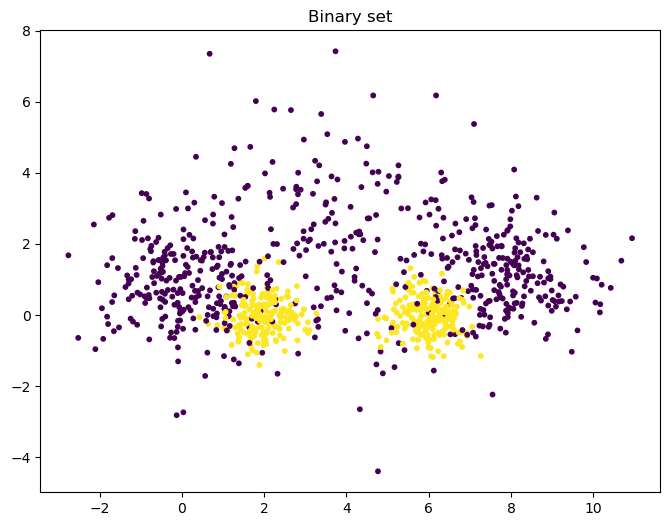

In [9]:
plt.figure(figsize=(8,6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=t2_train, s=10.0)
plt.title('Binary set')

# Part I: Linear classifiers
## Linear regression

We see that that set (X, t2) is far from linearly separable, and we will explore how various classifiers are able to handle this. We start with linear regression. You may make your own implementation from scratch or start with the solution to the weekly exercise set 7. 
We include it here with a little added flexibility.

In [10]:
def add_bias(X, bias):
    """X is a Nxm matrix: N datapoints, m features
    bias is a bias term, -1 or 1. Use 0 for no bias
    Return a Nx(m+1) matrix with added bias in position zero
    """
    N = X.shape[0]
    biases = np.ones((N, 1))*bias # Make a N*1 matrix of bias-s
    # Concatenate the column of biases in front of the columns of X.
    return np.concatenate((biases, X), axis  = 1) 

In [350]:
class NumpyClassifier():
    """Common methods to all numpy classifiers --- if any"""

    # Mean squared error (Used in Task:Loss)
    # def MSE(self, t_train, y_pred):
    #     N = len(y_pred)
    #     sum = 0
    #     for j in range(N):
    #         sum += (t_train[j] - y_pred[j])**2
    #     return sum/N
    def MSE(self, x, y):
        return sum((x - y)**2)/x.shape[0]
    
    # Logistic (Used in Logistic Regression)
    def logistic(self, x):
        return 1/(1+np.exp(-x))
    
    # Binary cross-entropy loss for logistic regression
    def BCE(self, x, t_train, y_pred):
        N = len(y_pred)
        sum = 0
        for j in range(N):
            for i in range(len(x[0])):
                sum += -(t_train[j] - y_pred[j])*x[j][i]
        return sum/N
    


In [358]:
class NumpyLinRegClass(NumpyClassifier): # Gradient descent batch training?

    def __init__(self, bias=-1):
        self.bias=bias
    
    def fit(self, X_train, t_train, X_val, t_val, eta = 0.1, epochs=10):
        # eta - learning rate
        """X_train is a Nxm matrix, N data points, m features
        t_train is a vector of length N,
        the targets values for the training data"""

        X_train_no_bias = np.copy(X_train)
        
        if self.bias:
            X_train = add_bias(X_train, self.bias)
            
        (N, m) = X_train.shape
        
        self.weights = weights = np.zeros(m)
        # Added for Task:Loss {
        self.loss = loss = []
        self.e_accuracy = e_accuracy = []
        #}

        for e in range(epochs):
            weights -= eta / N *  X_train.T @ (X_train @ weights - t_train)
            # Task: loss {
            loss.append(self.MSE(t_train, self.predict(X_train_no_bias)))
            e_accuracy.append(np.mean(self.predict(X_val) == t_val))
            # }
    
    # Task:Loss {
    def mse_loss(self):
        return self.loss
    
    def epoch_accuracy(self):
        return self.e_accuracy
    # }
    
    def predict(self, X, threshold=0.5):
        """X is a Kxm matrix for some K>=1
        predict the value for each point in X"""
        if self.bias:
            X = add_bias(X, self.bias)
        ys = X @ self.weights
        return ys > threshold

We can train and test a first classifier.

In [346]:
def accuracy(predicted, gold):
    return np.mean(predicted == gold)

In [359]:
cl = NumpyLinRegClass()
cl.fit(X_train, t2_train, X_val, t2_val)
accuracy(cl.predict(X_val), t2_val)

0.522

The following is a small procedure which plots the data set together with the decision boundaries. 
You may modify the colors and the rest of the graphics as you like.
The procedure will also work for multi-class classifiers

In [16]:
def plot_decision_regions(X, t, clf=[], size=(8,6)):
    """Plot the data set (X,t) together with the decision boundary of the classifier clf"""
    # The region of the plane to consider determined by X
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    # Make a make of the whole region
    h = 0.02  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    # Classify each meshpoint.
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=size) # You may adjust this

    # Put the result into a color plot
    plt.contourf(xx, yy, Z, alpha=0.2, cmap = 'Paired')

    plt.scatter(X[:,0], X[:,1], c=t, s=10.0, cmap='Paired')

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("Decision regions")
    plt.xlabel("x0")
    plt.ylabel("x1")

#    plt.show()

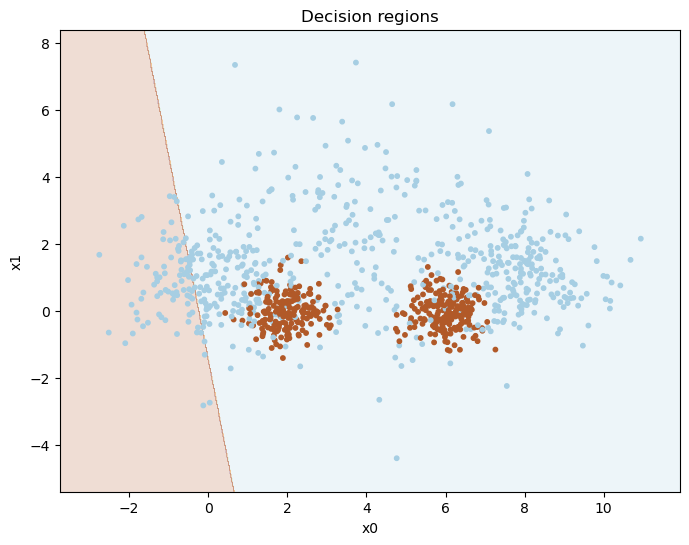

In [354]:
plot_decision_regions(X_train, t2_train, cl)

### Task: Tuning

The result is far from impressive. 
Remember that a classifier which always chooses the majority class will have an accuracy of 0.6 on this data set.

Your task is to try various settings for the two training hyper-parameters, *eta* and *epochs*, to get the best accuracy on the validation set. 

Report how the accuracy vary with the hyper-parameter settings. It it not sufficient to give the final hyperparemters. You must also show how you found them  and results for alternative values you tried out.

When you are satisfied with the result, you may plot the decision boundaries, as above.

In [348]:
# Finding best hyper-parameters for scaled data
def test_hyperpars(X_train, t_train, X_val, t_val, cl = cl):
    # Testing various eta and epochs to increase accuracy

    # varying eta and epochs and plotting accuracy
    n = 200 # number of datapoints
    eta_values = np.linspace(1.0, 1e-6, n)
    epoch_values = np.linspace(1, 200, n, dtype = int)
    accuracies_eta = []
    accuracies_epoch = []
    accuracies_both = []

    for et in eta_values:
        cl.fit(X_train, t_train, X_val, t_val, eta = et)
        accuracies_eta.append(cl.epoch_accuracy()[-1])

    for ep in epoch_values:
        cl.fit(X_train, t_train, X_val, t_val, epochs = ep)
        accuracies_epoch.append(cl.epoch_accuracy()[-1])    

    for et, ep in zip(eta_values, epoch_values):
        cl.fit(X_train, t_train, X_val, t_val, eta = et, epochs = ep)
        accuracies_both.append(cl.epoch_accuracy()[-1]) 

    fig = plt.figure(figsize = (10, 7))
    ax = fig.add_subplot(projection='3d')
    ax.scatter(eta_values, [10]*n, accuracies_eta, label = "Testing learning rate")
    ax.scatter([0.1]*n, epoch_values, accuracies_epoch, label = "Testing training cycles")
    ax.scatter(eta_values, epoch_values, accuracies_both, label = "Testing both")
    ax.set_xlabel('Eta - learning rate')
    ax.set_ylabel('Epochs - training cycles')
    ax.set_zlabel('Accuracy')
    plt.legend()
    plt.show()

    # Finding best accuracies for eta and epochs alone, and testing new precicion with those values
    print('Best accuracies found testing only eta values and only epoch values: \n')
    print('Best accuracy in the eta test: ',np.max(accuracies_eta), '\nBest accuracy in the epochs test: ',np.max(accuracies_epoch))
    i_eta = accuracies_eta.index(np.max(accuracies_eta))
    i_epoch = accuracies_epoch.index(np.max(accuracies_epoch))
    print('\nEta value yielding best accuracy: ',eta_values[i_eta], '\nEpochs value yielding best accuracy: ',epoch_values[i_epoch],'\n')

    cl.fit(X_train, t_train, X_val, t_val, eta = eta_values[i_eta], epochs = epoch_values[i_epoch])
    print("Accuracy using best eta value and epochs value found seperately: ", accuracy(cl.predict(X_val), t_val))

    print('\nBest accuracy when testing for both eta values and epochs values simultaneously: ',np.max(accuracies_both))
    index = accuracies_both.index(np.max(accuracies_both))
    print('Best eta value: ', eta_values[index], '\nBest epochs value: ', epoch_values[index])

    cl.fit(X_train, t_train, X_val, t_val, eta = eta_values[index], epochs = epoch_values[index])
    print("Final accuracy: ", accuracy(cl.predict(X_val), t_val))

    return eta_values[index], epoch_values[index]

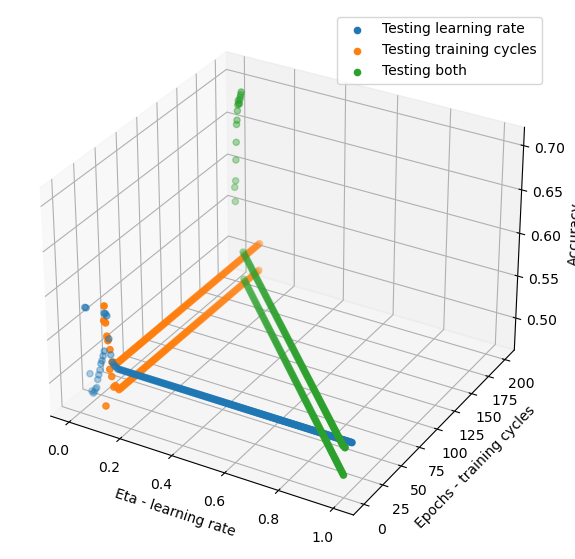

Best accuracies found testing only eta values and only epoch values: 

Best accuracy in the eta test:  0.576 
Best accuracy in the epochs test:  0.592

Eta value yielding best accuracy:  0.08040292964824114 
Epochs value yielding best accuracy:  3 

Accuracy using best eta value and epochs value found seperately:  0.502

Best accuracy when testing for both eta values and epochs values simultaneously:  0.704
Best eta value:  0.07537780904522606 
Best epochs value:  185
Final accuracy:  0.704


In [349]:
best_eta, best_epochs = test_hyperpars(X_train, t2_train, X_val, t2_val)

The effect of the hyper-parameter settings on the accuracy is visualized in the plot above. 

The final hyper-parameter settings are set to eta = 0.075 and epochs = 185, yielding an accuracy of 0.704.

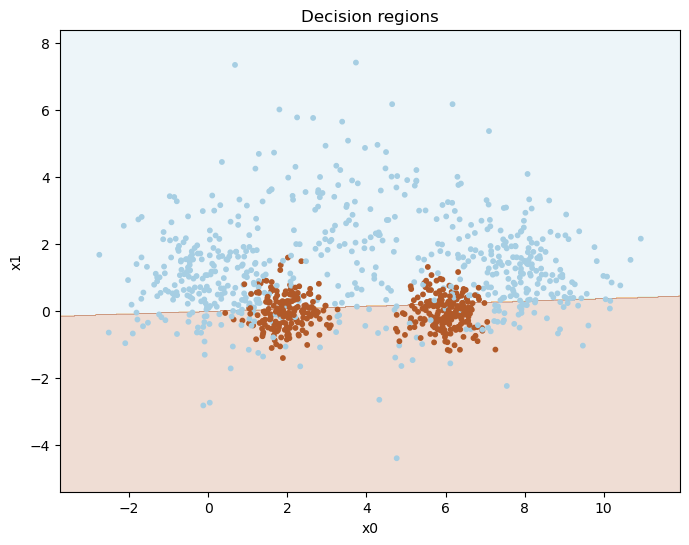

In [23]:
plot_decision_regions(X_train, t2_train, cl)

### Task: Loss
The linear regression classifier is trained with mean squared error loss. So far, we have not calculated the loss explicitly in the code. Extend the code to calculate the loss on the training set for each epoch and to store the losses such that the losses can be inspected after training. 

Also extend the classifier to calculate the accuracy on the training data after each epoch.

Train a classifier with your best settings from last point. After training, plot the loss as a function of the number of epochs. Then plot the accuracy as a function of the number of epochs.

Comment on what you see: Are the function monotone? Is this as expected?

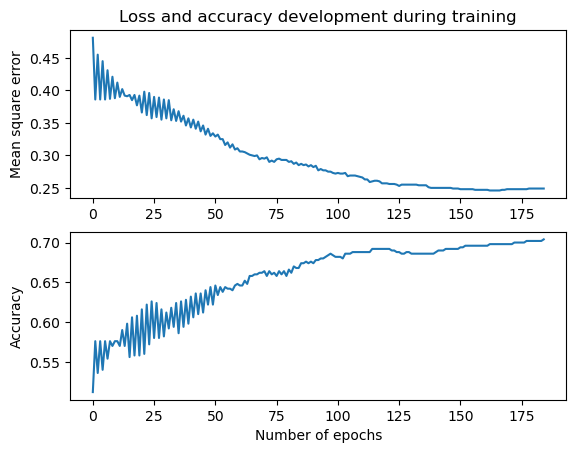

In [355]:
# Training with best hyper-parameter settings
cl.fit(X_train, t2_train, X_val, t2_val, eta = best_eta, epochs = best_epochs)

losses = cl.mse_loss()
accuracies = cl.epoch_accuracy()


fig, ax = plt.subplots(2)
ax[0].plot(range(best_epochs), losses)
ax[0].set_ylabel('Mean square error')
ax[1].plot(range(best_epochs), accuracies)
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Number of epochs')
ax[0].set_title('Loss and accuracy development during training')
plt.show()

#### Comment:
Neither functions are monotone, but the loss function is overall decreasing, and the accuracy function is overall increasing. 
It is not expected that the functions are not monotone, and can be due to a high learning rate.

### Task: Scaling

we have seen in the lectures that scaling the data may improve training speed. 

- Implement a scaler, either standard scaler (normalizer) or max-min scaler 
- Scale the data
- Train the model on the scaled data
- Experiment with hyper-parameter settings and see whether you can speed  up  the training.
- Report final hyper-meter settings and show how you found them.
- Plot the loss curve and the accuracy curve for the classifier trained on scaled data with the best settings you found.

In [25]:
# Implementing scaler (normalizer)

def scale(data, dim):
    if (dim == 2):
        m_i = np.mean(data) 
        s_i = np.std(data) 

        scaled = np.zeros_like(data)
        for i in range(len(scaled)): # rows
            for j in range(len(scaled[0])): # columns
                scaled[i][j] = (data[i][j] - m_i)/s_i
    
    if (dim == 1):
        m_i = np.mean(data)
        s_i = np.std(data)

        scaled = np.zeros_like(data)
        for i in range(len(data)):
            scaled[i] = (data[i] - m_i)/s_i
        
    return scaled

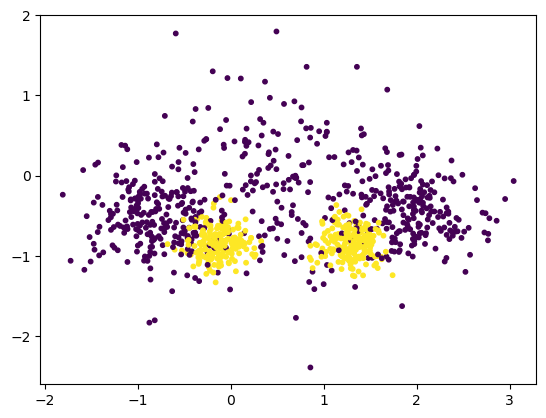

In [26]:
# Scaling data
scaled_X_train = scale(X_train, 2)
scaled_t2_train = scale(t2_train, 1)
scaled_X_val = scale(X_val, 2)
scaled_t2_val = scale(t2_val, 1)


# Plotting the scaled data
plt.scatter(scaled_X_train[:, 0], scaled_X_train[:, 1], c = scaled_t2_train, s = 10.0)
plt.show()

Using function from earlier to experiment with hyper-parameter settings.

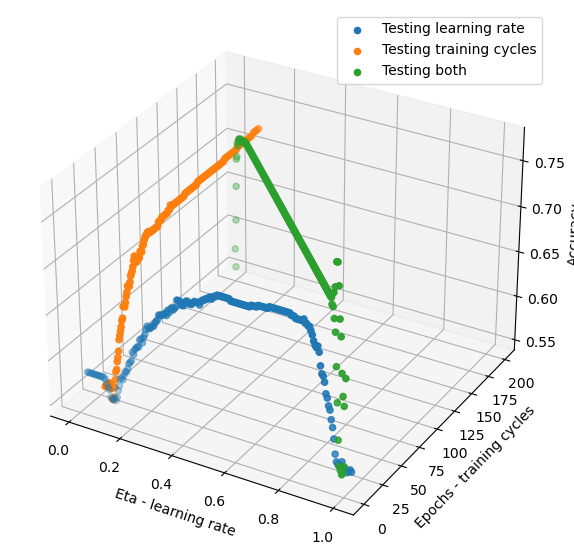

Best accuracies found testing only eta values and only epoch values: 

Best accuracy in the eta test:  0.708 
Best accuracy in the epochs test:  0.722

Eta value yielding best accuracy:  0.7738919597989949 
Epochs value yielding best accuracy:  192 

Accuracy using best eta value and epochs value found seperately:  0.722

Best accuracy when testing for both eta values and epochs values simultaneously:  0.77
Best eta value:  0.9296552763819095 
Best epochs value:  15
Final accuracy:  0.77


In [27]:
best_scaled_eta, best_scaled_epochs = test_hyperpars(scaled_X_train, scaled_t2_train, scaled_X_val, scaled_t2_val)

In [362]:
# Training with best hyper-parameter settings for scaled data
cl = NumpyLinRegClass()
cl.fit(scaled_X_train, scaled_t2_train, scaled_X_val, scaled_t2_val, eta = best_scaled_eta, epochs = best_scaled_epochs)
print('Improved accuracy using scaled data: ',cl.epoch_accuracy()[-1])
print('Optimal eta and epochs values:', '\neta: ', best_scaled_eta, '\nepochs: ', best_scaled_epochs)

Improved accuracy using scaled data:  0.77
Optimal eta and epochs values: 
eta:  0.9296552763819095 
epochs:  15


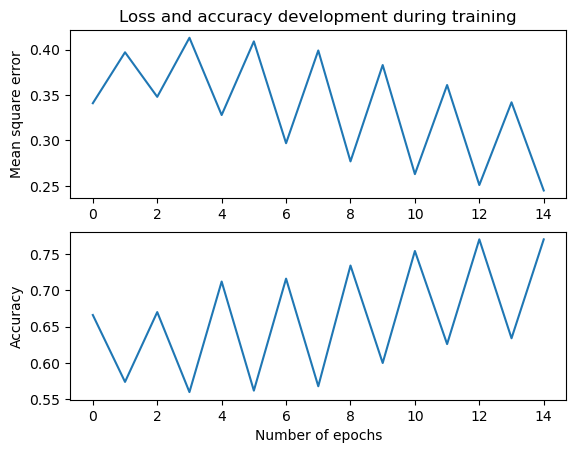

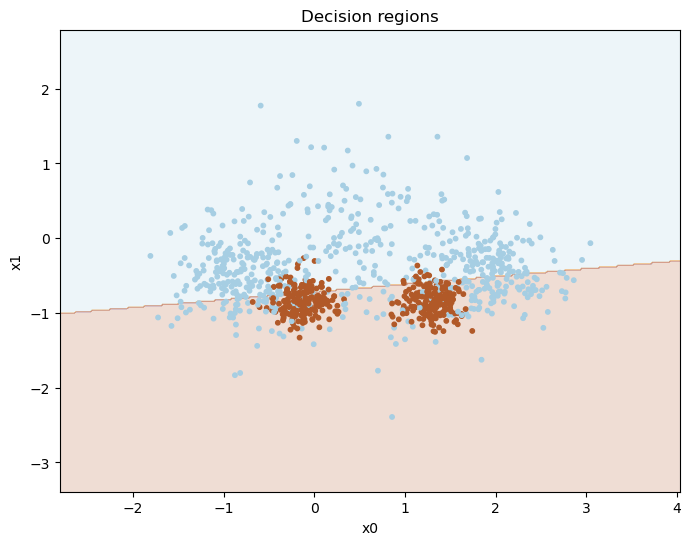

In [29]:
# plotting the loss and the accuracy curve for the classifier trained 
# on scaled data with the best settings found.
losses = cl.mse_loss()
accuracies = cl.epoch_accuracy()

fig, ax = plt.subplots(2)
ax[0].plot(range(best_scaled_epochs), losses)
ax[0].set_ylabel('Mean square error')
ax[1].plot(range(best_scaled_epochs), accuracies)
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Number of epochs')
ax[0].set_title('Loss and accuracy development during training')
plt.show()

# plotting decision regions just to see
plot_decision_regions(scaled_X_train, scaled_t2_train, cl)

## Logistic regression
a) You should now implement a logistic regression classifier similarly to the classifier based on linear regression.
You may use code from the solution to weekly exercise set week07.

b) In addition to the method `predict` which predicts a class for the data, include a method `predict_probability` which predicts the probability of the data belonging to the positive class.

c) As with the classifier based on linear regression, we want to calculate loss and accuracy after each epoch.
The prefered loss for logistic regression is binary cross-entropy. You could have used mean squared error. The most important is that your implementation of the loss corresponds to your implementation of the gradient descent.

d) In addition, extend the fit-method with optional arguments for a validation set (X_val, t_val). If a validation set is included in the call to fit, calculate the loss and the accuracy for the validation set after each epoch. 

e) The training runs for a number of epochs. We cannot know beforehand for how many epochs it is reasonable to run the training. One possibility is to run the training until the learning does not improve much. Extend the fit-method with two keyword arguments, `tol` and `n_epochs_no_update` and stop training when the loss has not improved with more than `tol` after running `n_epochs_no_update` epochs. A possible default value for `n_epochs_no_update` is 5. Also, add an attribute to the classifier which tells us after fitting how many epochs were ran.

f) Train classifiers with various learning rates, and with varying values for `tol` for finding optimal values. Also consider the effect of scaling the data.

g) After a succesful training, plot both training loss and validation loss as functions of the number of epochs in one figure, and both accuracies as functions of the number of epochs in another figure. Comment on what you see.

In [289]:
# Week 7 solution + my own additions:

class NumpyLogReg(NumpyClassifier):

    def __init__(self, bias = 0):
        self.bias = bias
             
    def fit(self, X_train, t_train, X_val, t_val, tol, eta = 0.1, n_epochs_no_update = 5):
        """X_train is a Nxm matrix, N data points, m features
        t_train is avector of length N,
        the targets values for the training data"""

        X_train_no_bias = np.copy(X_train)
        
        (N, m) = X_train.shape
        X_train = add_bias(X_train, 0)
        
        self.weights = weights = np.zeros(m+1)
        self.loss = loss = []
        self.val_loss = val_loss = []
        self.e_accuracy = e_accuracy = []

        i = 0
        test_loss = tol - 1
        for _ in range(200):
            i += 1
            if i > 15 and test_loss < tol:
                # print(f'{n_epochs_no_update} epochs were ran')
                # print('Accuracy: ', e_accuracy[-1])
                self.final_epochs = n_epochs_no_update
                break

            for e in range(n_epochs_no_update):
                weights -= eta / N *  X_train.T @ (self.forward(X_train) - t_train)   
                loss.append(self.BCE(X_train, t_train, self.predict(X_train_no_bias)))
                val_loss.append(self.BCE(X_train, t_train, self.predict(X_val)))
                e_accuracy.append(np.mean(self.predict(X_val) == t_val))
            test_loss = np.abs(loss[-1] - loss[(n_epochs_no_update - 5)])
            n_epochs_no_update += 1 

    
    def get_number_of_epochs(self):
        return self.final_epochs
    
    def forward(self, X):
        return self.logistic(X @ self.weights)
    
    def predict(self, x, threshold=0.5):
        """X is a Kxm matrix for some K>=1
        predict the value for each point in X"""
        z = add_bias(x, 0)
        return (self.forward(z) > threshold).astype('int')
    
    def predict_probability(self, x):
        """Predicts probability of the data
        belonging to the positive class"""
        s = add_bias(x, 0)
        return self.logistic(s @ self.weights)
    
    def bce_loss(self):
        return self.loss[-self.final_epochs:]

    def validation_loss(self):
        return self.val_loss[-self.final_epochs:]
    
    def epoch_accuracy(self):
        return self.e_accuracy[-self.final_epochs:]


In [283]:
lr_cl = NumpyLogReg()
lr_cl.fit(X_train, t2_train, X_val, t2_val, 0.5)

print(lr_cl.epoch_accuracy()[-1], lr_cl.get_number_of_epochs())

0.706 33


In [246]:
#lr_cl.fit(X_train, t2_train, X_val, t2_val, 0.1, eta = 0.5)

# Finding best hyper-parameters for scaled data
def test_eta_tol(X_train, t_train, X_val, t_val, default_tol):
    # Testing various eta and epochs to increase accuracy

    # varying eta and epochs and plotting accuracy
    n = 25 # number of datapoints
    eta_values = np.linspace(2, 1e-4, n)
    tol_values = np.linspace(0.001, 1, n)
    tol = default_tol
    accuracies_eta = []
    accuracies_tol = []
    accuracies_both = []

    for et in eta_values:
        lr_cl.fit(X_train, t_train, X_val, t_val, tol, eta = et)
        accuracies_eta.append(lr_cl.epoch_accuracy()[-1])

    for t in tol_values:
        lr_cl.fit(X_train, t_train, X_val, t_val, t)
        accuracies_tol.append(lr_cl.epoch_accuracy()[-1])  

    for et, t in zip(eta_values, tol_values):
        lr_cl.fit(X_train, t_train, X_val, t_val, t, eta = et)
        accuracies_both.append(lr_cl.epoch_accuracy()[-1]) 

    fig = plt.figure(figsize = (10, 7))
    ax = fig.add_subplot(projection='3d')
    ax.scatter(eta_values, [tol]*n, accuracies_eta, label = "Testing learning rate")
    ax.scatter([0.1]*n, tol_values, accuracies_tol, label = "Testing tolerance")
    ax.scatter(eta_values, tol_values, accuracies_both, label = "Testing both")
    ax.set_xlabel('Eta - learning rate')
    ax.set_ylabel('Tol - training cycles tolerance')
    ax.set_zlabel('Accuracy')
    plt.legend()
    plt.show()

    # Finding best accuracies for eta and tol alone, and testing new precicion with those values
    print('Best accuracies found testing only eta values and only epoch values: \n')
    print('Best accuracy in the eta test: ',np.max(accuracies_eta), '\nBest accuracy in the tol test: ',np.max(accuracies_tol))
    i_eta = accuracies_eta.index(np.max(accuracies_eta))
    i_tol = accuracies_tol.index(np.max(accuracies_tol))
    print('\nEta value yielding best accuracy: ',eta_values[i_eta], '\nTol value yielding best accuracy: ',tol_values[i_tol],'\n')

    lr_cl.fit(X_train, t_train, X_val, t_val, tol_values[i_tol], eta = eta_values[i_eta])
    print("Accuracy using best eta value and tol value found seperately: ", lr_cl.epoch_accuracy()[-1])

    print('\nBest accuracy when testing for both eta values and tol values simultaneously: ',np.max(accuracies_both))
    index = accuracies_both.index(np.max(accuracies_both))
    print('Best eta value: ', eta_values[index], '\nBest tol value: ', tol_values[index])

    lr_cl.fit(X_train, t_train, X_val, t_val, tol_values[index], eta = eta_values[index])

    return eta_values[index], tol_values[index]

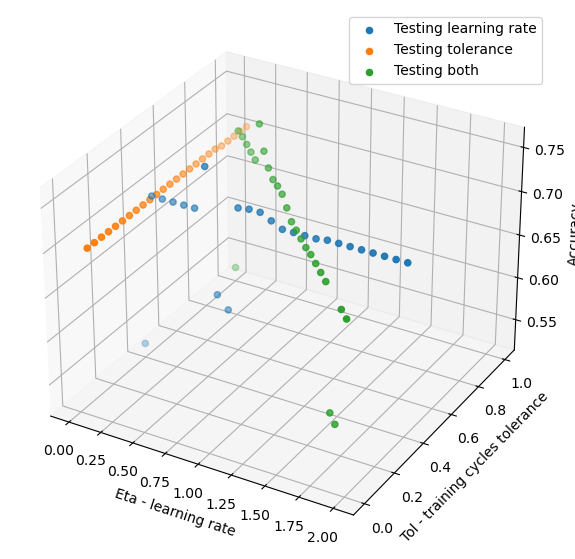

Best accuracies found testing only eta values and only epoch values: 

Best accuracy in the eta test:  0.756 
Best accuracy in the tol test:  0.706

Eta value yielding best accuracy:  0.500075 
Tol value yielding best accuracy:  0.001 

Accuracy using best eta value and tol value found seperately:  0.756

Best accuracy when testing for both eta values and tol values simultaneously:  0.756
Best eta value:  0.500075 
Best tol value:  0.7502500000000001


In [247]:
eta_v, tol_v = test_eta_tol(X_train, t2_train, X_val, t2_val, 0.4)

In [248]:
print(lr_cl.get_number_of_epochs(), lr_cl.epoch_accuracy()[-1])

21 0.756


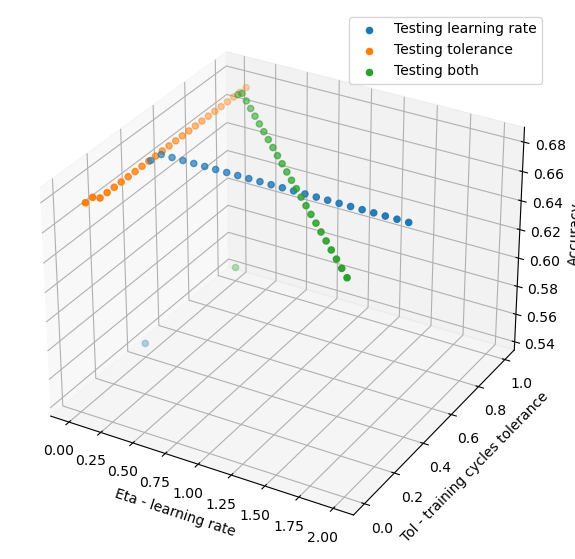

Best accuracies found testing only eta values and only epoch values: 

Best accuracy in the eta test:  0.68 
Best accuracy in the tol test:  0.68

Eta value yielding best accuracy:  2.0 
Tol value yielding best accuracy:  0.001 

Accuracy using best eta value and tol value found seperately:  0.68

Best accuracy when testing for both eta values and tol values simultaneously:  0.68
Best eta value:  2.0 
Best tol value:  0.001


In [249]:
# Same test on scaled data:

scaled_eta_v, scaled_tol_v = test_eta_tol(scaled_X_train, scaled_t2_train, scaled_X_val, scaled_t2_val, 0.4)

In [265]:
print(lr_cl.get_number_of_epochs(), lr_cl.epoch_accuracy()[-1])

33 0.706


In [284]:
# Final training using the best data (not scaled)

lr_cl.fit(X_train, t2_train, X_val, t2_val, tol_v, eta_v)

print(lr_cl.epoch_accuracy()[-1], lr_cl.get_number_of_epochs())

0.756 21


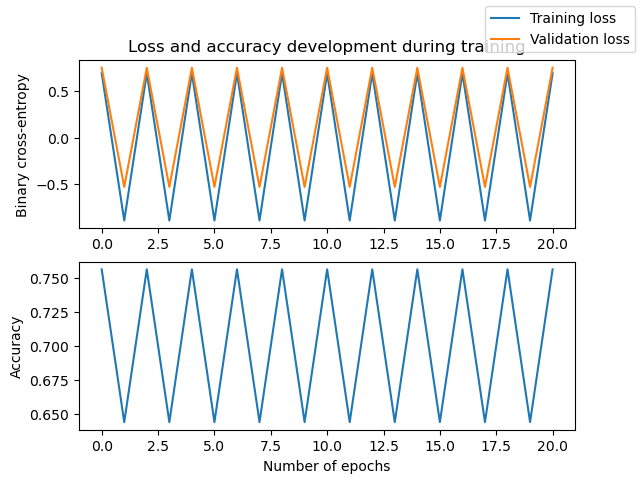

In [287]:
# Plotting training loss and validation loss vs. epochs
# Plotting accuracies vs. epochs

epochs = lr_cl.get_number_of_epochs()
losses = lr_cl.bce_loss()
val_losses = lr_cl.validation_loss()
accuracies = lr_cl.epoch_accuracy()

fig, ax = plt.subplots(2)
ax[0].plot(range(epochs), losses, label = 'Training loss')
ax[0].plot(range(epochs), val_losses, label = 'Validation loss')
ax[0].set_ylabel('Binary cross-entropy')
ax[1].plot(range(epochs), accuracies)
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Number of epochs')
ax[0].set_title('Loss and accuracy development during training')
fig.legend()
plt.show()


## Multi-class classifiers
We turn to the task of classifying when there are more than two classes, and the task is to ascribe one class to each input. We will now use the set (X, t_multi).

### "One-vs-rest" with logistic regression
We saw in the lecture how a logistic regression classifier can be turned into a multi-class classifier using the one-vs-rest approach. We train one logistic regression classifier for each class. To predict the class of an item, we run all the binary classifiers and collect the probability score from each of them. We assign the class which ascribes the highest probability.

Build such a classifier. Train the resulting classifier on (X_train, t_multi_train), test it on (X_val, t_multi_val), tune the hyper-parameters and report the accuracy.

Also plot the decision boundaries for your best classifier similarly to the plots for the binary case.

In [292]:
def fit_classes(X_train, t_multi_train, X_val, t_multi_val, C = 5):
    # C - number of classes
    models = []
    for i in range(C):
        t_hot = t_multi_train[:, i]
        lr_cl = NumpyLogReg()
        y = lr_cl.fit(X_train, t_hot, X_val, )
        models.append(y)
        X_val, t2_val, tol_v, eta_v


# I am struggeling to implement this and understanding what to do
          

In [393]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
enc.fit(X_train, t_multi_train)
t_hot = enc.transform(X_train)


# print(t_hot)

# I am trying to find the one hot encoded version of t_multi, 
# but I cannot understand how to

# Part II Multi-layer neural networks

## A first non-linear classifier

The following code it a simple implementation of a multi-layer perceptron.
It is quite restricted.
There is only one hidden layer.
It can only handle binary classification.
In addition, it uses a simple final layer similar to the linear regression classifier above.
One way to look at it is what happens when we add a hidden layer to the linear regression classifier.

It can be used to make a non-linear classifier for the set (X, t2).
Experiment with settings for learning rate and epochs and see how good results you can get.
Report results for variouse settings.
Be prepared to train for a looooong time.
Plot the training set together with the decision regions as in part I.

In [293]:
class MLPBinaryLinRegClass(NumpyClassifier):
    """A multi-layer neural network with one hidden layer"""
    
    def __init__(self, bias=-1, dim_hidden = 6):
        """Intialize the hyperparameters"""
        self.bias = bias
        self.dim_hidden = dim_hidden
        
        def logistic(x):
            return 1/(1+np.exp(-x))
        self.activ = logistic
        
        def logistic_diff(y):
            return y * (1 - y)
        self.activ_diff = logistic_diff
        
    def fit(self, X_train, t_train, eta=0.001, epochs = 100):
        """Intialize the weights. Train *epochs* many epochs.
        
        X_train is a Nxm matrix, N data points, m features
        t_train is a vector of length N of targets values for the training data, 
        where the values are 0 or 1.
        """
        self.eta = eta
        
        T_train = t_train.reshape(-1,1)
            
        dim_in = X_train.shape[1] 
        dim_out = T_train.shape[1]
        
        # Itilaize the wights
        self.weights1 = (np.random.rand(
            dim_in + 1, 
            self.dim_hidden) * 2 - 1)/np.sqrt(dim_in)
        self.weights2 = (np.random.rand(
            self.dim_hidden+1, 
            dim_out) * 2 - 1)/np.sqrt(self.dim_hidden)
        X_train_bias = add_bias(X_train, self.bias)
        
        for e in range(epochs):
            # One epoch
            hidden_outs, outputs = self.forward(X_train_bias)
            # The forward step
            out_deltas = (outputs - T_train)
            # The delta term on the output node
            hiddenout_diffs = out_deltas @ self.weights2.T
            # The delta terms at the output of the jidden layer
            hiddenact_deltas = (hiddenout_diffs[:, 1:] * 
                                self.activ_diff(hidden_outs[:, 1:]))  
            # The deltas at the input to the hidden layer
            self.weights2 -= self.eta * hidden_outs.T @ out_deltas
            self.weights1 -= self.eta * X_train_bias.T @ hiddenact_deltas 
            # Update the weights
            
    def forward(self, X):
        """Perform one forward step. 
        Return a pair consisting of the outputs of the hidden_layer
        and the outputs on the final layer"""
        hidden_activations = self.activ(X @ self.weights1)
        hidden_outs = add_bias(hidden_activations, self.bias)
        outputs = hidden_outs @ self.weights2
        return hidden_outs, outputs
    
    def predict(self, X):
        """Predict the class for the mebers of X"""
        Z = add_bias(X, self.bias)
        forw = self.forward(Z)[1]
        score= forw[:, 0]
        return (score > 0.5)

In [306]:
def fit_accuracy(predicted, gold):
    return np.mean(predicted == gold)

In [368]:
mlp = MLPBinaryLinRegClass()
mlp.fit(X_train, t2_train)

print(fit_accuracy(mlp.predict(X_val), t2_val))

0.77


In [308]:
for epochs in [10, 20, 50, 100, 200, 500, 1000, 10000]:
    mlp = MLPBinaryLinRegClass()
    mlp.fit(X_train, t2_train, epochs=epochs)
    accuracy_mlp = fit_accuracy(mlp.predict(X_val), t2_val)
    print("epochs: {:8}  accuracy: {:10.3f}".format(epochs, accuracy_mlp))

epochs:       10  accuracy:      0.538
epochs:       20  accuracy:      0.576
epochs:       50  accuracy:      0.828
epochs:      100  accuracy:      0.648
epochs:      200  accuracy:      0.830
epochs:      500  accuracy:      0.792
epochs:     1000  accuracy:      0.838
epochs:    10000  accuracy:      0.858


In [366]:
for eta in [10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]:
    mlp = MLPBinaryLinRegClass()
    mlp.fit(X_train, t2_train, eta = eta)
    accuracy_mlp = fit_accuracy(mlp.predict(X_val), t2_val)
    print("eta: {:8}  accuracy: {:10.3f}".format(eta, accuracy_mlp))

eta:       10  accuracy:      0.576
eta:        1  accuracy:      0.576
eta:      0.1  accuracy:      0.576
eta:     0.01  accuracy:      0.424
eta:    0.001  accuracy:      0.782
eta:   0.0001  accuracy:      0.590
eta:    1e-05  accuracy:      0.548
eta:    1e-06  accuracy:      0.510


/var/folders/qp/v9d822514d39n5b42h3_wy100000gn/T/ipykernel_43913/3619876166.py:10: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))
/var/folders/qp/v9d822514d39n5b42h3_wy100000gn/T/ipykernel_43913/3619876166.py:46: RuntimeWarning: overflow encountered in matmul
  hiddenout_diffs = out_deltas @ self.weights2.T
/var/folders/qp/v9d822514d39n5b42h3_wy100000gn/T/ipykernel_43913/3619876166.py:48: RuntimeWarning: invalid value encountered in multiply
  hiddenact_deltas = (hiddenout_diffs[:, 1:] *


From the results above I am choosing to move forward in testing with an eta of 0.001

In [341]:
n = 10
epochss = np.linspace(10, 100000, n, dtype = 'int')

for epochs in epochss:
    mlp = MLPBinaryLinRegClass()
    mlp.fit(X_train, t2_train, eta = 0.001, epochs = epochs)
    accuracy_mlp = fit_accuracy(mlp.predict(X_val), t2_val)
    print("epochs: {:8}  accuracy: {:10.5f}".format(epochs, accuracy_mlp))

epochs:       10  accuracy:    0.54800
epochs:    11120  accuracy:    0.85400
epochs:    22230  accuracy:    0.88800
epochs:    33340  accuracy:    0.89400
epochs:    44450  accuracy:    0.84400
epochs:    55560  accuracy:    0.85200
epochs:    66670  accuracy:    0.85000
epochs:    77780  accuracy:    0.84200
epochs:    88890  accuracy:    0.82400
epochs:   100000  accuracy:    0.87000


In [343]:
n = 7
epochss = np.linspace(100000, 190000, n, dtype = 'int')

for epochs in epochss:
    mlp = MLPBinaryLinRegClass()
    mlp.fit(X_train, t2_train, eta = 0.001, epochs = epochs)
    accuracy_mlp = fit_accuracy(mlp.predict(X_val), t2_val)
    print("epochs: {:8}  accuracy: {:10.5f}".format(epochs, accuracy_mlp))

epochs:   100000  accuracy:    0.84000
epochs:   115000  accuracy:    0.88800
epochs:   130000  accuracy:    0.86200
epochs:   145000  accuracy:    0.86200
epochs:   160000  accuracy:    0.90200
epochs:   175000  accuracy:    0.85800
epochs:   190000  accuracy:    0.83800


In [365]:
mlp = MLPBinaryLinRegClass()
mlp.fit(X_train, t2_train, eta = 0.001, epochs = 500000)
accuracy_mlp = fit_accuracy(mlp.predict(X_val), t2_val)
print(accuracy_mlp)

0.88


In [373]:
# As the accuracy is around 0.85 for epochs from 11 000 to 500 000, 
# I will select the number of epochs to be 30 000

mlp = MLPBinaryLinRegClass()
mlp.fit(X_train, t2_train, eta = 0.001, epochs = 30000)
accuracy_mlp = fit_accuracy(mlp.predict(X_val), t2_val)
print(accuracy_mlp)

0.84


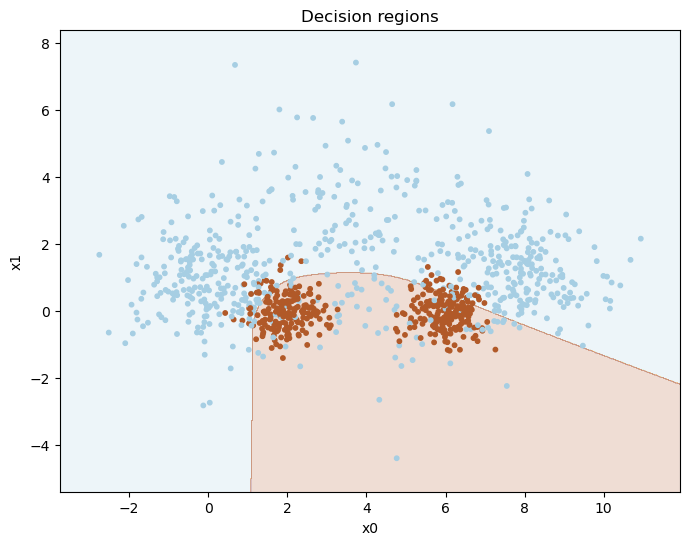

In [374]:
# plotting decision regions

plot_decision_regions(X_train, t2_train, mlp)

## Improving the classifier
You should now make changes to the classifier similarly to what you did with the logistic regression classifier in part 1.

a) In addition to the method predict, which predicts a class for the data, include a method predict_probability which predict the probability of the data belonging to the positive class. The training should be based on this value as with logistic regression.

b) Calculate the loss and the accuracy after each epoch and store them for inspection after training.

c) In addition, extend the fit-method with optional arguments for a validation set (X_val, t_val). If a validation set is included in the call to fit, calculate the loss and the accuracy for the validation set after each epoch.

d) The training runs for a number of epochs. We cannot know beforehand for how many epochs it is reasonable to run the training. One possibility is to run the training until the learning does not improve much. Extend the fit method with two keyword arguments, `tol` and `n_epochs_no_update` and stop training when the loss has not improved with more than tol after `n_epochs_no_update`. A possible default value for `n_epochs_no_update` is 5. Also, add an attribute to the classifier which tells us after fitting how many epochs were ran.

e) Tune the hyper-parameters:`eta`, `tol`and `dim-hidden`.
Also consider the effect of scaling the data.

f) After a succesful training with a best setting for the hyper-parameters, plot both training loss and validation loss as functions of the number of epochs in one figure, and both accuracies as functions of the number of epochs in another figure. Comment on what you see.

g) The algorithm contains an element of non-determinism. Hence, train the classifier 10 times with the optimal hyper-parameters and report the mean and standard deviation of the accuracies over the 10 runs.

# Part III: Final testing
We can now perform a final testing on the held-out test set.

## Binary task (X, t2)
Consider the linear regression classifier, the logistic regression classifier and the multi-layer network with the best settings you found. Train each of them on the training set and calculate accuracy on the held-out test set, but also on the validation set and the training set. Report in a 3 by 3 table.

Comment on what you see. How do the three different algorithms compare? Also, compare the results between the different data sets. In cases like these, one might expect slightly inferior results on the held-out test data compared to the validation data. Is that the case here? 

Also report precision and recall for class 1.